In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import sqlite3
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
import warnings 
warnings.filterwarnings("ignore")

In [2]:
data = "./data/cleaned_data/cleaned_data.db"

conn = sqlite3.connect(data)
#cur = conn.cursor()

#df_batting = pd.read_sql_query("SELECT * FROM batting_clean", conn)
#df_people = pd.read_sql_query("SELECT * FROM people_clean", conn)
#df_app = pd.read_sql_query("SELECT * FROM appearance_clean", conn)
#df_fielding = pd.read_sql_query("SELECT * FROM fielding_clean", conn)
#df_teams = pd.read_sql_query("SELECT * FROM teams_clean", conn)
#df_franch = pd.read_sql_query("SELECT * FROM franch_clean", conn)
#df_parks = pd.read_sql_query("SELECT * FROM parks_clean", conn)
df_main = pd.read_sql_query("SELECT * FROM main_clean", conn)

conn.close()

"""
print("Batting")
display(df_batting.head(5))
print("\n People \n")
display(df_people.head(5))
print("\n Fielding \n")
display(df_fielding.head(5))
print("\n Parks \n")
display(df_parks.head(5))
print("\n Teams \n")
display(df_teams.head(5))
"""

df_main.sort_values(by=['playerID', 'yearID'], inplace=True)
display(df_main.head())

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,weight,age,yoe,yoe_adj,ops_per_delta,bo_season,bo_ever,franchID,name,park
7102,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,190.0,28,3,1,-0.065559,0,0,CHW,Chicago White Sox,Comiskey Park II
2983,abbotku01,1995,1,FLO,NL,120,420,60,107,18,...,180.0,26,2,1,0.124114,0,0,FLA,Florida Marlins,Joe Robbie Stadium
4900,abbotku01,1996,1,FLO,NL,109,320,37,81,18,...,180.0,27,3,2,-0.044944,0,0,FLA,Florida Marlins,Joe Robbie Stadium
4468,abbotku01,1997,1,FLO,NL,94,252,35,69,18,...,180.0,28,4,3,0.016012,0,0,FLA,Florida Marlins,Joe Robbie Stadium
6254,abbotku01,1999,1,COL,NL,96,286,41,78,17,...,180.0,30,6,4,-0.009162,0,0,COL,Colorado Rockies,Coors Field


In [3]:
df_main.dtypes

playerID          object
yearID             int64
stint              int64
teamID            object
lgID              object
G                  int64
AB                 int64
R                  int64
H                  int64
2B                 int64
3B                 int64
HR                 int64
RBI                int64
SB                 int64
CS                 int64
BB                 int64
SO                 int64
IBB                int64
HBP                int64
SH                 int64
SF                 int64
GIDP               int64
1B                 int64
TB                 int64
obp              float64
slg              float64
ops              float64
final_yr_adj       int64
debut_yr           int64
missed_any         int64
bt_same            int64
p_pos             object
height           float64
weight           float64
age                int64
yoe                int64
yoe_adj            int64
ops_per_delta    float64
bo_season          int64
bo_ever            int64


At one point, we considered adding a skill level factor, where we could update with bayes prior or classification of elite, regular, sub-par. However, there was not enough time properly incorporate this into the xgboost model.

Add mising factors and any additional data prep.

In [4]:
# calculate exponential weighted moving average up to the given year
# do this before ops value shift
df_skill = df_main[['playerID', 'yearID', 'teamID', 'lgID', 'height', 'weight', 'age', 'p_pos',
                    'bt_same', 'AB', 'yoe', 'yoe_adj', 'obp', 'slg', 'ops']]


df_skill.sort_values(['playerID', 'yearID'], inplace=True, ignore_index=True)

alpha = 0.75

df_ops_mean = df_skill.groupby(['playerID'])['ops'].ewm(alpha=alpha, min_periods=1).mean()
df_ops_mean = df_ops_mean.to_frame()
df_ops_mean = df_ops_mean.reset_index()
df_ops_mean = df_ops_mean.rename(columns={'ops':'ops_ewm'})
df_ops_mean.drop(columns=['level_1'], inplace=True)

df_skill = df_skill.join(df_ops_mean, how='inner', rsuffix='_r')
df_skill.drop(columns='playerID_r', inplace=True)
display(df_skill.head())

,playerID,yearID,teamID,lgID,height,weight,age,p_pos,bt_same,AB,yoe,yoe_adj,obp,slg,ops,ops_ewm
0,abbotje01,2000,CHA,AL,74.0,190.0,28,OF,0,215,3,1,0.343096,0.395349,0.738445,0.738445
1,abbotku01,1995,FLO,NL,71.0,180.0,26,SS,1,420,2,1,0.317597,0.452381,0.769978,0.769978
2,abbotku01,1996,FLO,NL,71.0,180.0,27,SS,1,320,3,2,0.307246,0.428125,0.735371,0.742293
3,abbotku01,1997,FLO,NL,71.0,180.0,28,SS,1,252,4,3,0.314607,0.432540,0.747146,0.745991
4,abbotku01,1999,COL,NL,71.0,180.0,30,SS,1,286,6,4,0.310231,0.430070,0.740301,0.741707


Shift ops value on a grouped by player basis.
Shift ops so a players ops value for the following year (ops_future) can be used as the label value.
Then drop rows where ops_future == 0.0 and yearID < 2020, which occurs when a player has no future years to compare to (they either played their final season or didn't meet our inclusion criteria for any remaining years).
The yearID < 2020 is not dropped because that is the newest year in the dataset, i.e. we can predict values for those players after the model has been trained and tested. 

In [5]:
# Shift future ops value on a grouped by player basis
df_skill.sort_values(['playerID', 'yearID'], inplace=True, ignore_index=True)
df_skill['ops_future'] = df_skill.groupby(['playerID'])['ops'].shift(periods=-1, fill_value=0) 

# Drop when ops_future is 0 (players final year) except when the year is 2020 (because we are predicting their future)
df_exclude = df_skill[(df_skill['ops_future'] == 0.0) & (df_skill['yearID'] < 2020)]
df_model = df_skill[~df_skill.isin(df_exclude)].dropna() 

print(len(df_model.index))
display(df_model.head())

9824


,playerID,yearID,teamID,lgID,height,weight,age,p_pos,bt_same,AB,yoe,yoe_adj,obp,slg,ops,ops_ewm,ops_future
1,abbotku01,1995.0,FLO,NL,71.0,180.0,26.0,SS,1.0,420.0,2.0,1.0,0.317597,0.452381,0.769978,0.769978,0.735371
2,abbotku01,1996.0,FLO,NL,71.0,180.0,27.0,SS,1.0,320.0,3.0,2.0,0.307246,0.428125,0.735371,0.742293,0.747146
3,abbotku01,1997.0,FLO,NL,71.0,180.0,28.0,SS,1.0,252.0,4.0,3.0,0.314607,0.432540,0.747146,0.745991,0.740301
4,abbotku01,1999.0,COL,NL,71.0,180.0,30.0,SS,1.0,286.0,6.0,4.0,0.310231,0.430070,0.740301,0.741707,0.671772
8,abreubo01,1998.0,PHI,NL,72.0,220.0,24.0,OF,0.0,497.0,2.0,1.0,0.408547,0.496982,0.905529,0.905529,0.995070


Cast column types to clean up any incorrect columns.

Identify category columns that will be used in the model and use One Hot Encoding technique/create dummy columns.

Remove yearID 2020 from the dataset as those rows can only be run after the model has finished training and testing.

Separate the attributes for the model from the values to predict (ops_future).

In [34]:
# need to fix column types
model_cols = {'yearID': 'int32', 'age': 'int32', 'bt_same': 'int32', 'AB': 'int32', 'yoe_adj': 'int32'}
df_model = df_model.astype(model_cols)

# Need to create dummy columns before filtering out 2020
df_model_extra = df_model[['playerID', 'yearID', 'teamID', 'lgID', 'height', 'weight', 'age', 'p_pos', 'AB', 'bt_same', 'yoe_adj', 'obp', 'slg', 'ops_ewm', 'ops_future']]


cat_factors = ['teamID', 'lgID', 'p_pos']
df_extra_dummies = pd.get_dummies(df_model_extra, columns=cat_factors)


# For Final 2020 Prediction
df_model_2020 = df_extra_dummies[df_extra_dummies['yearID'] >= 2020]
df_X_2020 = df_model_2020.drop(columns=['playerID', 'ops_future'])
# no Y values for 2020 


# Players will not have a future ops value for 2020, need to remove those rows from the dataframe before spliting
# Excluding 2019 from training/testing sets because 2019 ops future is 2020 ops, which was impacted by Covid.
df_include = df_extra_dummies[df_extra_dummies['yearID'] < 2019]

# Split dataframe into model parameters and output value
df_X = df_include.drop(columns=['playerID', 'ops_future'])
df_Y = df_include[['ops_future']]

print(len(df_include.index))
display(df_X.head())
display(df_Y.head())


9545


,yearID,height,weight,age,AB,bt_same,yoe_adj,obp,slg,ops_ewm,...,teamID_TOR,teamID_WAS,lgID_AL,lgID_NL,p_pos_1B,p_pos_2B,p_pos_3B,p_pos_C,p_pos_OF,p_pos_SS
1,1995,71.0,180.0,26,420,1,1,0.317597,0.452381,0.769978,...,0,0,0,1,0,0,0,0,0,1
2,1996,71.0,180.0,27,320,1,2,0.307246,0.428125,0.742293,...,0,0,0,1,0,0,0,0,0,1
3,1997,71.0,180.0,28,252,1,3,0.314607,0.432540,0.745991,...,0,0,0,1,0,0,0,0,0,1
4,1999,71.0,180.0,30,286,1,4,0.310231,0.430070,0.741707,...,0,0,0,1,0,0,0,0,0,1
8,1998,72.0,220.0,24,497,0,1,0.408547,0.496982,0.905529,...,0,0,0,1,0,0,0,0,1,0


,ops_future
1,0.735371
2,0.747146
3,0.740301
4,0.671772
8,0.995070


In [7]:
df_X.dtypes

yearID          int32
height        float64
weight        float64
age             int32
AB              int32
bt_same         int32
yoe_adj         int32
obp           float64
slg           float64
ops_ewm       float64
teamID_ANA      uint8
teamID_ARI      uint8
teamID_ATL      uint8
teamID_BAL      uint8
teamID_BOS      uint8
teamID_CAL      uint8
teamID_CHA      uint8
teamID_CHN      uint8
teamID_CIN      uint8
teamID_CLE      uint8
teamID_COL      uint8
teamID_DET      uint8
teamID_FLO      uint8
teamID_HOU      uint8
teamID_KCA      uint8
teamID_LAA      uint8
teamID_LAN      uint8
teamID_MIA      uint8
teamID_MIL      uint8
teamID_MIN      uint8
teamID_ML4      uint8
teamID_MON      uint8
teamID_NYA      uint8
teamID_NYN      uint8
teamID_OAK      uint8
teamID_PHI      uint8
teamID_PIT      uint8
teamID_SDN      uint8
teamID_SEA      uint8
teamID_SFN      uint8
teamID_SLN      uint8
teamID_TBA      uint8
teamID_TEX      uint8
teamID_TOR      uint8
teamID_WAS      uint8
lgID_AL   

Split the data into training and testing datasets.

Gradient boosted tree models, similar to random forest models, typicallly do not need a validation set. By design, the algorithm refraines from adding significant bias to the model because it considers a plethora of unique trees constructed from a random combination of columns and rows. It is still not a bad idea to separate the data into a trianing and testing set, if there is enough data for the model, and due to the inherint properties of a gradient boosted model, we used a smaller then normal testing set, 20% of the data.

In [8]:
# Need to define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)

Prior to training the model, we will first perform hyperparameter tuning of the model.

To speed up CV and help prevent overfitting, select subset of data
and subset of columns per tree.

In [9]:
#M = len(X.columns) # 54

param_grid = {
    'max_depth': [3,4,5], # out of 5,6,7 -> 5 ; 3,4,5 -> 3
    'learning_rate': [0.04, 0.05, 0.06], # out of 0.03, 0.05, 0.07, .1 -> 0.05; .04,.05,.06 -> .06
    'gamma': [0, 0.05, 0.1], # out of 0,0.25,1.0 -> 0 ; 0,.05,.1 -> 0
    'reg_lambda': [0, 1.0, 10.0], # out of 0, 1.0, 10 -> 10
    'n_estimators': [1000],
    'colsample_bytree': [.7, .8, .9], # out of .3, .5, .7 -> .7 ; .7,.8,.9 -> .9
    'subsample': [.9]
}

# Additional parameters to consider
# - subsample
# - criterion ; default is friedman_mse; according to sklearn, this is generally the best 
# - min_samples_split
# - min_impurity_split
# - max_features ; typically M/3 for regression
# - colsample_bytree
# - colsample_bylevel
# - colsample_bynode
# - gamma ; minimum loss reduction required to make a further partition on a leaf node


clf_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

xgb_grid = GridSearchCV(estimator=clf_reg,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = 10,
                        verbose=0,
                        cv=5)

xgb_grid.fit(X_train,
            y_train,
            early_stopping_rounds=10,
            #eval_metric='neg_root_mean_squared_error',
            eval_set=[(X_test, y_test)],
            verbose=False)

#print(xgb_grid)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
      

In [10]:
xgb_grid.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.06,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_lambda': 10.0,
 'subsample': 0.9}

In [11]:
xgb_grid.best_score_

-0.08361918573238548

In [12]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=42,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

Build final model after parameter optimization

In [9]:
# Add optimized parameters
clf_xgb = xgb.XGBRegressor(seed=42,
                            objective='reg:squarederror',
                            gamma=0, # 0 -> 0.5 -> 0
                            learn_rate=0.06, # 0.06 -> 0.04 -> 0.05
                            max_depth=3, # 3 -> 5 -> 4
                            reg_lambda=10,
                            subsample=0.9, 
                            colsample_bytree=0.9) # .9 -> .7 -> .9 -> .8

clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            #eval_metric='rmse',
            eval_set=[(X_test, y_test)])

[14:23:49] WARNING: ..\src\learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.20134
[1]	validation_0-rmse:0.15321
[2]	validation_0-rmse:0.12337
[3]	validation_0-rmse:0.10549
[4]	validation_0-rmse:0.09513
[5]	validation_0-rmse:0.08955
[6]	validation_0-rmse:0.08675
[7]	validation_0-rmse:0.08527
[8]	validation_0-rmse:0.08422
[9]	validation_0-rmse:0.08380
[10]	validation_0-rmse:0.08347
[11]	validation_0-rmse:0.08322
[12]	validation_0-rmse:0.08308
[13]	validation_0-rmse:0.08297
[14]	validation_0-rmse:0.08289
[15]	validation_0-rmse:0.08283
[16]	validation_0-rmse:0.08278
[17]	validation_0-rmse:0.08278
[18]	validation_0-rmse:0.08271
[19]	validation_0-rmse:0.08277
[20]	validation_0-rmse:0.08268
[21]	validation_0-rmse:0.0825

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learn_rate=0.06, learning_rate=0.300000012, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
             scale_pos_weight=1, seed=42, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [10]:
clf_xgb.feature_importances_

array([0.02752431, 0.02826086, 0.02820252, 0.02197422, 0.01937706,
       0.01254067, 0.01701491, 0.01520099, 0.01529507, 0.2804697 ,
       0.        , 0.        , 0.00936741, 0.        , 0.00733773,
       0.        , 0.00869272, 0.01343867, 0.01032987, 0.02192951,
       0.0081091 , 0.01321555, 0.        , 0.02071277, 0.0123612 ,
       0.00382119, 0.01625426, 0.        , 0.01241335, 0.03657069,
       0.        , 0.01161976, 0.01127307, 0.        , 0.        ,
       0.01297909, 0.01532981, 0.02001715, 0.01405669, 0.01350917,
       0.        , 0.01323698, 0.01019753, 0.0046828 , 0.00570433,
       0.0128909 , 0.        , 0.01457431, 0.        , 0.01519145,
       0.02664562, 0.10013821, 0.03753875], dtype=float32)

Feature Importance can be seen below, however, it is important to note that meaning behind these results is not necessarily consistent with what's displayed. This is expecially true for the dummy variable columns as we cannot simply sum them into one value as the feature importance of the model does not necessarily capture the assoication between them.

In [11]:
cols = X_train.columns
feature_vals = clf_xgb.feature_importances_

col_vals = [(x,y) for x, y in zip(cols,feature_vals)]
col_vals

[('yearID', 0.02752431),
 ('height', 0.028260859),
 ('weight', 0.028202519),
 ('age', 0.021974219),
 ('AB', 0.019377062),
 ('bt_same', 0.012540674),
 ('yoe_adj', 0.017014913),
 ('obp', 0.0152009865),
 ('slg', 0.01529507),
 ('ops_ewm', 0.2804697),
 ('teamID_ANA', 0.0),
 ('teamID_ARI', 0.0),
 ('teamID_ATL', 0.009367406),
 ('teamID_BAL', 0.0),
 ('teamID_BOS', 0.007337732),
 ('teamID_CAL', 0.0),
 ('teamID_CHA', 0.008692724),
 ('teamID_CHN', 0.013438668),
 ('teamID_CIN', 0.010329869),
 ('teamID_CLE', 0.021929506),
 ('teamID_COL', 0.008109096),
 ('teamID_DET', 0.013215547),
 ('teamID_FLO', 0.0),
 ('teamID_HOU', 0.020712769),
 ('teamID_KCA', 0.012361202),
 ('teamID_LAA', 0.0038211916),
 ('teamID_LAN', 0.016254256),
 ('teamID_MIA', 0.0),
 ('teamID_MIL', 0.012413349),
 ('teamID_MIN', 0.036570687),
 ('teamID_ML4', 0.0),
 ('teamID_MON', 0.01161976),
 ('teamID_NYA', 0.011273072),
 ('teamID_NYN', 0.0),
 ('teamID_OAK', 0.0),
 ('teamID_PHI', 0.012979094),
 ('teamID_PIT', 0.015329811),
 ('teamID_SDN',

Plot Graph Visualization

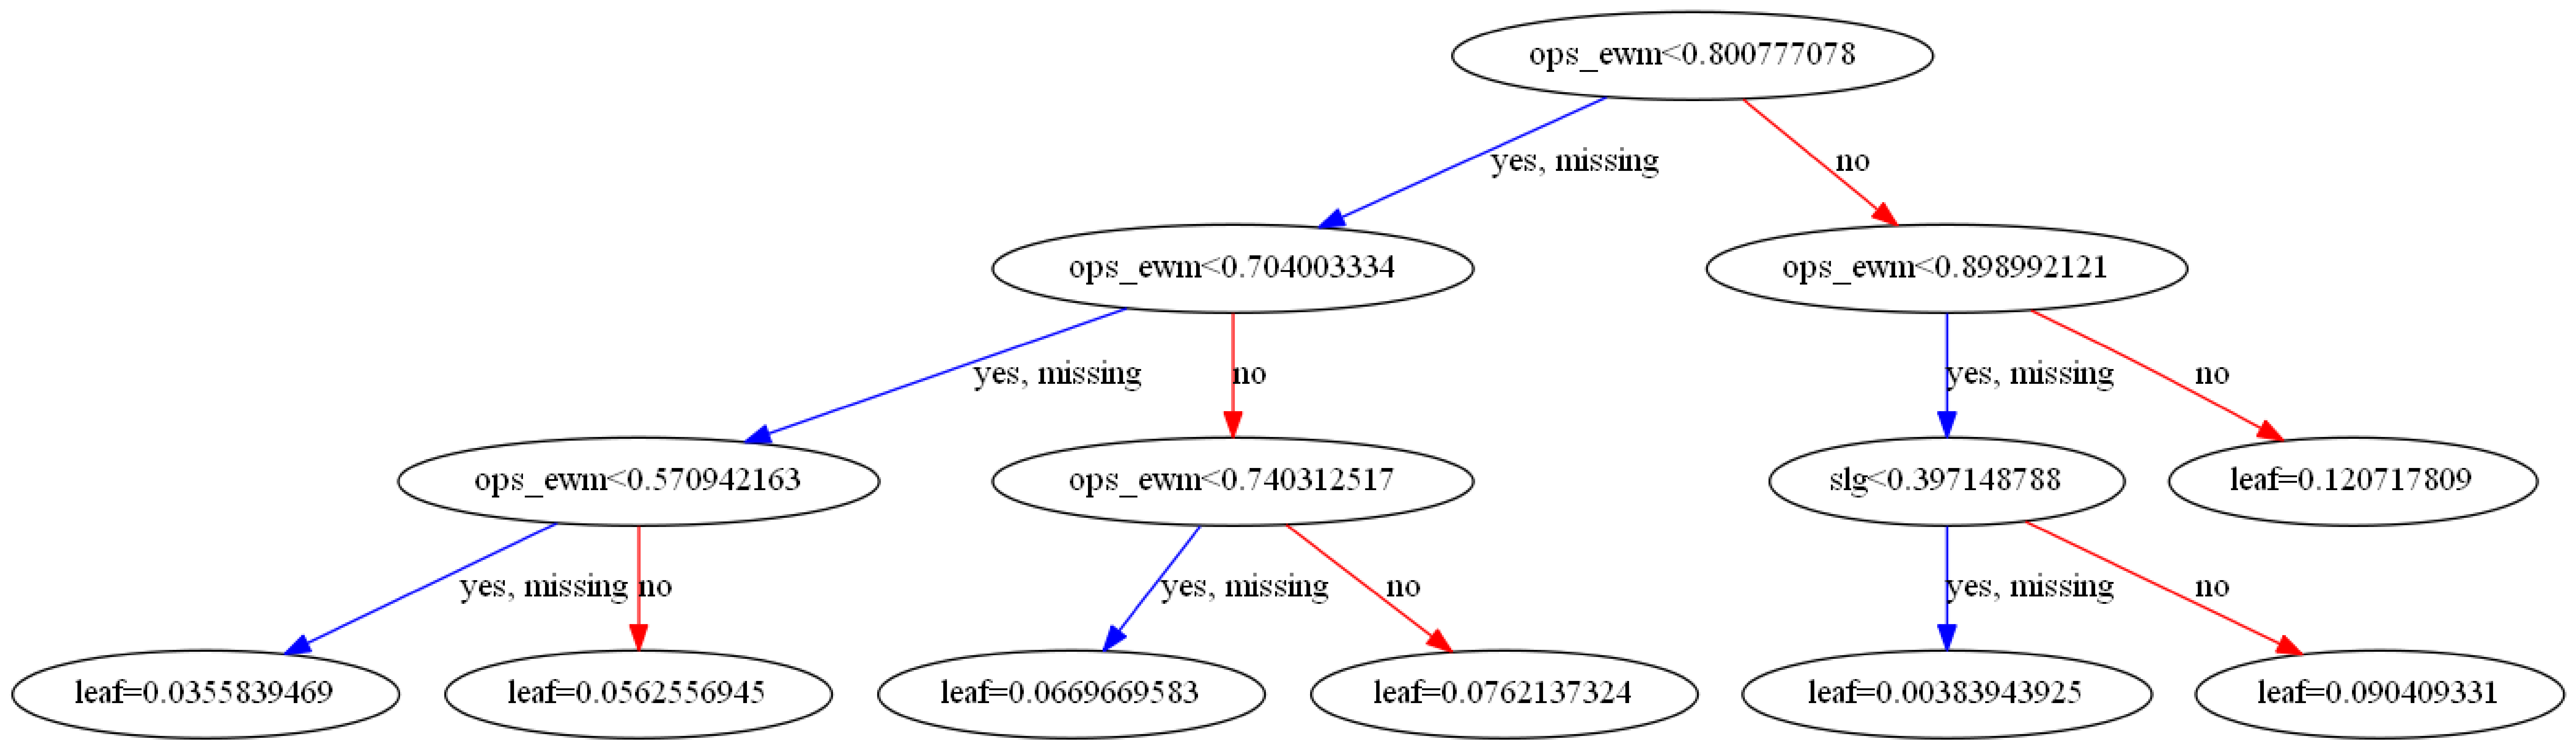

In [12]:
xgb.plot_tree(clf_xgb)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Final Tree

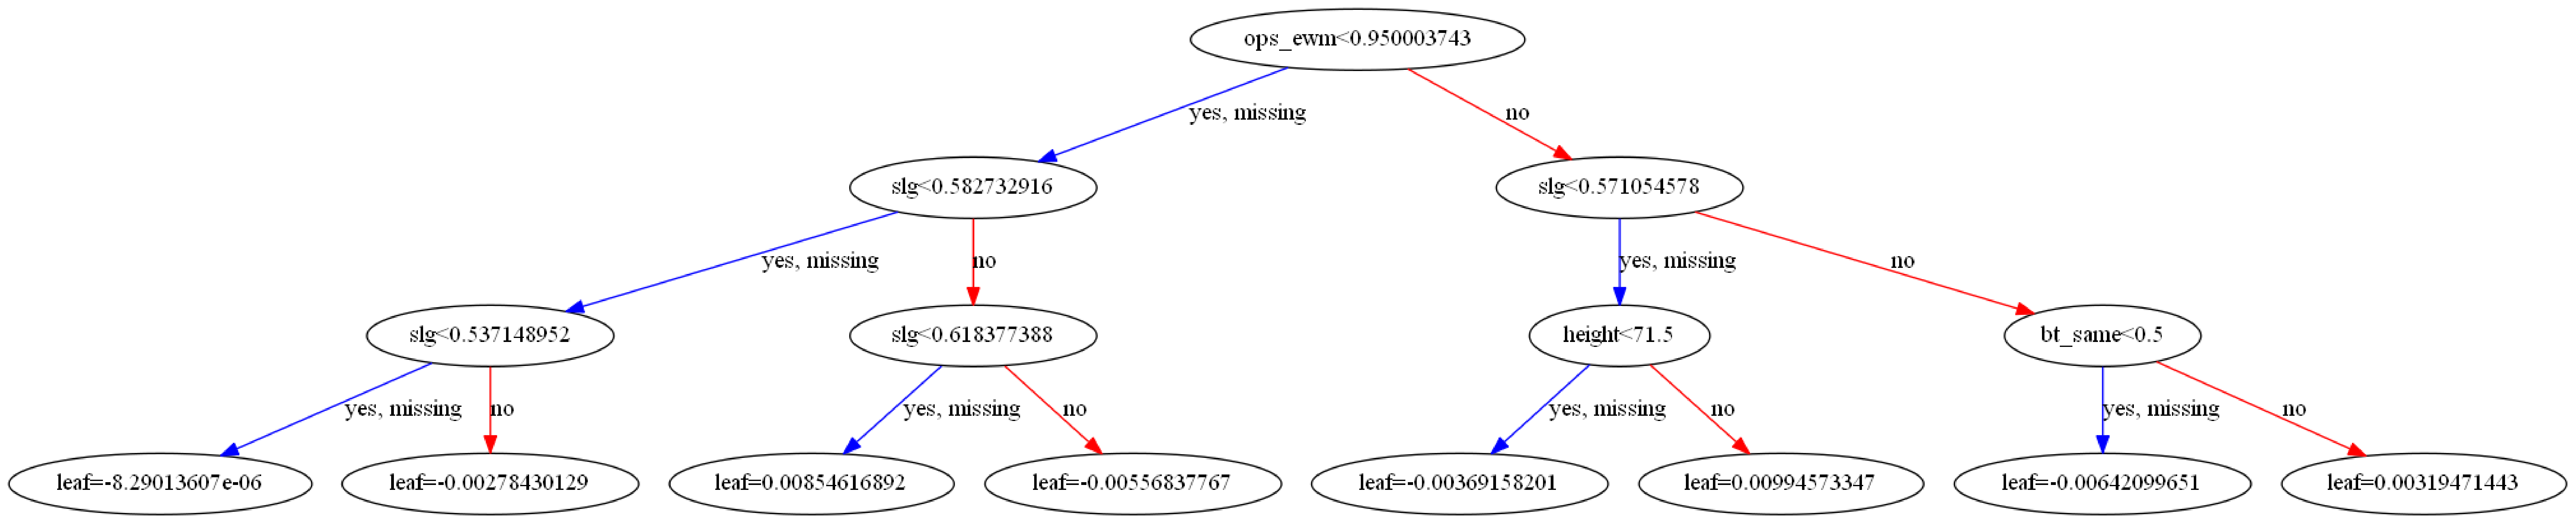

In [39]:
xgb.plot_tree(clf_xgb, num_trees=79)
fig4 = plt.gcf()
fig4.set_size_inches(150, 100)
fig4.savefig('final_tree.png')

Get predicted model values

In [13]:
y_pred = clf_xgb.predict(df_X)
y_vals = pd.Series(y_pred).to_frame().rename(columns={0: 'y_pred'})

print(len(y_vals.index))
y_vals.head()

9545


,y_pred
0,0.758666
1,0.733836
2,0.757520
3,0.729778
4,0.914995


In [14]:
# --------------- Possibly move this to data prep -------------------
# Need Breakout Season Labels for Confustion Matrix an accuracy of breakout season prediction
df_breakout = df_main[['playerID', 'yearID', 'bo_season']]
df_breakout.sort_values(by=['playerID', 'yearID'], inplace=True)
df_breakout['bo_future'] = df_breakout.groupby(['playerID'])['bo_season'].shift(periods=-1, fill_value=0)
df_breakout.drop_duplicates(subset=['playerID', 'yearID'], inplace=True)

print(len(df_breakout.index))
display(df_breakout.head())

11593


,playerID,yearID,bo_season,bo_future
7102,abbotje01,2000,0,0
2983,abbotku01,1995,0,0
4900,abbotku01,1996,0,0
4468,abbotku01,1997,0,0
6254,abbotku01,1999,0,0


Join predicted values to dataframe that was used to split the data.
Merge bo_season label back onto dataframe.

In [15]:
# Need to reset index of df_include so prediction indices match
# No need to reset index anymore becasue creating a new dataframe
df_include_reset = df_model[df_model['yearID'] < 2019].reset_index()
print(len(df_include_reset.index))

df_compare = df_include_reset.join(y_vals, how='inner') # join predicted values on index
print(len(df_compare.index))

df_compare = df_compare.merge(df_breakout, how='inner', on=['playerID', 'yearID'])
df_compare.drop_duplicates(subset=['playerID', 'yearID'], inplace=True)
print(len(df_compare.index))

display(df_compare.head())

9545
9545
9545


,index,playerID,yearID,teamID,lgID,height,weight,age,p_pos,bt_same,...,yoe,yoe_adj,obp,slg,ops,ops_ewm,ops_future,y_pred,bo_season,bo_future
0,1,abbotku01,1995,FLO,NL,71.0,180.0,26,SS,1,...,2.0,1,0.317597,0.452381,0.769978,0.769978,0.735371,0.758666,0,0
1,2,abbotku01,1996,FLO,NL,71.0,180.0,27,SS,1,...,3.0,2,0.307246,0.428125,0.735371,0.742293,0.747146,0.733836,0,0
2,3,abbotku01,1997,FLO,NL,71.0,180.0,28,SS,1,...,4.0,3,0.314607,0.432540,0.747146,0.745991,0.740301,0.757520,0,0
3,4,abbotku01,1999,COL,NL,71.0,180.0,30,SS,1,...,6.0,4,0.310231,0.430070,0.740301,0.741707,0.671772,0.729778,0,0
4,8,abreubo01,1998,PHI,NL,72.0,220.0,24,OF,0,...,2.0,1,0.408547,0.496982,0.905529,0.905529,0.995070,0.914995,1,0


Create predicted column based on predicted ops values

In [16]:
#df_compare['pred_bo'] = np.where(df_compare['y_pred'] - df_compare['ops'] >= .175, 1, 0)
df_compare['pred_bo'] = np.where((df_compare['y_pred'] - df_compare['ops']) / df_compare['ops'] >= .175, 1, 0)
display(df_compare.head())

,index,playerID,yearID,teamID,lgID,height,weight,age,p_pos,bt_same,...,yoe_adj,obp,slg,ops,ops_ewm,ops_future,y_pred,bo_season,bo_future,pred_bo
0,1,abbotku01,1995,FLO,NL,71.0,180.0,26,SS,1,...,1,0.317597,0.452381,0.769978,0.769978,0.735371,0.758666,0,0,0
1,2,abbotku01,1996,FLO,NL,71.0,180.0,27,SS,1,...,2,0.307246,0.428125,0.735371,0.742293,0.747146,0.733836,0,0,0
2,3,abbotku01,1997,FLO,NL,71.0,180.0,28,SS,1,...,3,0.314607,0.432540,0.747146,0.745991,0.740301,0.757520,0,0,0
3,4,abbotku01,1999,COL,NL,71.0,180.0,30,SS,1,...,4,0.310231,0.430070,0.740301,0.741707,0.671772,0.729778,0,0,0
4,8,abreubo01,1998,PHI,NL,72.0,220.0,24,OF,0,...,1,0.408547,0.496982,0.905529,0.905529,0.995070,0.914995,1,0,0


Get Accuracy and corresponding values required to form confusion matrix

In [17]:
true_neg = len(df_compare[(df_compare['bo_future'] == 0) & (df_compare['pred_bo'] == 0)])
true_pos = len(df_compare[(df_compare['bo_future'] == 1) & (df_compare['pred_bo'] == 1)])
false_neg = len(df_compare[(df_compare['bo_future'] == 1) & (df_compare['pred_bo'] == 0)])
false_pos = len(df_compare[(df_compare['bo_future'] == 0) & (df_compare['pred_bo'] == 1)])

print(f"True Negatives: {true_neg}")
print(f"True Positives: {true_pos}")
print(f"False Negatives: {false_neg}")
print(f"False Positives: {false_pos}")

accuracy = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)
print(f"Accuracy: {accuracy}")

True Negatives: 8482
True Positives: 188
False Negatives: 761
False Positives: 114
Accuracy: 0.9083289680460974


Plot Confusion Matrix

In [18]:
y_act = pd.Series(df_compare['bo_future'], name='Actual')
y_pred = pd.Series(df_compare['pred_bo'], name='Predicted')

#y_act = pd.Series(df_compare['bo_season'])
#y_pred = pd.Series(df_compare['pred_bo'])

df_conf = pd.crosstab(y_act, y_pred)
#df_conf = df_compare[['bo_season', 'pred_bo']]
df_conf_norm = df_conf.div(df_conf.sum(axis=1), axis=0)

display(df_conf)
display(df_conf_norm)

# can turn into a nicer visualization later
#plot_confusion_matrix(df_conf_norm)

Predicted,0,1
Actual,,
0,8482,114
1,761,188


Predicted,0,1
Actual,,
0,0.986738,0.013262
1,0.801897,0.198103


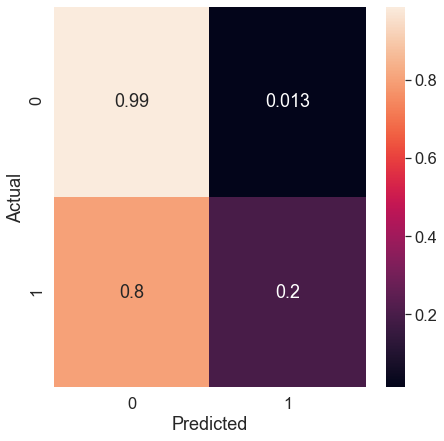

In [32]:
#disp = plot_confustion_matrix(clf_xgb, X_test, y_test)
fig2 = plt.figure(figsize=(7,7))
sn.set(font_scale=1.5)
sn.heatmap(df_conf_norm, annot=True)
fig2.savefig('xgboost_cm.png')

Calculate RMSE, MAE

In [20]:
df_compare['sq_e'] = (df_compare['y_pred'] - df_compare['ops_future'])**2
df_compare['abs_e'] = df_compare['y_pred'] - df_compare['ops_future']

rmse = (df_compare['sq_e'].sum() / len(df_compare.index))**0.5 
mae = df_compare['abs_e'].sum() / len(df_compare.index)

print(rmse)
print(mae)

0.07856076483266172
0.00013801252181242096


In [21]:
df_compare.to_csv("Compare_Results.csv", index=False)

looking at 2019 data

Predicted,0,1
Actual,,
0,180,9
1,28,6


Predicted,0,1
Actual,,
0,0.952381,0.047619
1,0.823529,0.176471


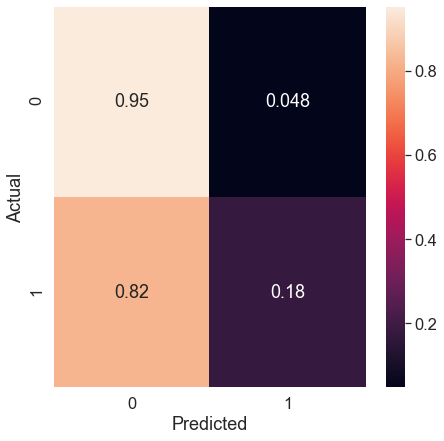

In [36]:

df_compare_2018 = df_compare[df_compare['yearID'] == 2018]

y_act_2019 = pd.Series(df_compare_2018['bo_future'], name='Actual')
y_pred_2019 = pd.Series(df_compare_2018['pred_bo'], name='Predicted')

df_conf_2019 = pd.crosstab(y_act_2019, y_pred_2019)
df_conf_norm_2019 = df_conf_2019.div(df_conf_2019.sum(axis=1), axis=0)

display(df_conf_2019)
display(df_conf_norm_2019)

fig3 = plt.figure(figsize=(7,7))
sn.set(font_scale=1.5)
sn.heatmap(df_conf_norm_2019, annot=True)
fig3.savefig('xgboost_cm_2019.png')

Predictions and output data for 2021 from 2020 data

In [22]:
# Predict 2021 ops values from 2020 data
pred_2021 = clf_xgb.predict(df_X_2020)

y_2021 = pd.Series(pred_2021).to_frame().rename(columns={0: 'y_2021'})
#display(y_2021.head()) # index is reset to 0. probably need to reset index on testing above before join

df_2020_all = df_model[df_model['yearID'] == 2020]
df_2020_all.reset_index(inplace=True) 
#display(df_2020_all.head())

df_2021_pred = df_2020_all.join(y_2021, how='inner') # join values on index
df_2021_pred = df_2021_pred.merge(df_breakout, on=['playerID', 'yearID'], how='inner')
df_2021_pred = df_2021_pred[['playerID', 'yearID', 'teamID', 'lgID', 'height', 'weight', 'age', 'p_pos', 'AB', 'bt_same', 'yoe_adj', 'obp', 'slg', 'ops_ewm', 'ops_future', 'y_2021', 'bo_season', 'bo_future']]
#display(df_2021_pred.head())


# Format 2021 predictions for visualization

df_2021_pred = df_2021_pred[['playerID', 'yearID', 'y_2021', 'bo_future', 'p_pos', 'teamID']]
df_2021_pred.rename(columns={'y_2021': 'pred_ops', 'bo_future':'pred_bo'}, inplace=True)

df_teams = pd.read_csv("./data/csv_data/core/Teams.csv")
df_teams_output = df_teams[['yearID', 'teamID', 'franchID', 'name', 'park']]
df_teams_output = df_teams_output[df_teams_output['yearID'] >= 1970]
df_output_2021 = df_2021_pred.merge(df_teams_output, how='inner', on=['yearID', 'teamID'])

# Using 2018 values (2019 predictions) due to Covid. 
df_2018 = df_compare[['playerID', 'yearID', 'y_pred', 'ops_future', 'bo_future', 'p_pos', 'teamID']]
df_2018 = df_2018[df_2018['yearID'] == 2018]
df_2018.rename(columns={'y_pred': 'pred_ops', 'bo_future':'pred_bo'}, inplace=True)
df_output_2019 = df_2018.merge(df_teams_output, how='inner', on=['yearID', 'teamID'])

# pred output is from 2018 for 2019 season
display(df_output_2019.head())
display(df_2021_pred.head())

,playerID,yearID,pred_ops,ops_future,pred_bo,p_pos,teamID,franchID,name,park
0,abreujo02,2018,0.823761,0.833602,0,1B,CHA,CHW,Chicago White Sox,Guaranteed Rate Field
1,anderti01,2018,0.737922,0.865175,1,SS,CHA,CHW,Chicago White Sox,Guaranteed Rate Field
2,castiwe01,2018,0.728421,0.684324,0,C,CHA,CHW,Chicago White Sox,Guaranteed Rate Field
3,engelad01,2018,0.758525,0.686904,0,OF,CHA,CHW,Chicago White Sox,Guaranteed Rate Field
4,garciav01,2018,0.814513,0.796288,0,OF,CHA,CHW,Chicago White Sox,Guaranteed Rate Field


,playerID,yearID,pred_ops,pred_bo,p_pos,teamID
0,abreujo02,2020,0.867089,0,1B,CHA
1,acunaro01,2020,0.841948,0,OF,ATL
2,adamewi01,2020,0.759046,0,SS,TBA
3,aguilje01,2020,0.765783,0,3B,MIA
4,ahmedni01,2020,0.751419,0,SS,ARI


In [23]:
df_output_2021.to_csv("boosted_2021_output.csv", index=False)
df_output_2019.to_csv("boosted_2019_output.csv", index=False)

References:

skikit-learn documentation

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

XGBoost documentation

@inproceedings{Chen:2016:XST:2939672.2939785,
 author = {Chen, Tianqi and Guestrin, Carlos},
 title = {{XGBoost}: A Scalable Tree Boosting System},
 booktitle = {Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
 series = {KDD '16},
 year = {2016},
 isbn = {978-1-4503-4232-2},
 location = {San Francisco, California, USA},
 pages = {785--794},
 numpages = {10},
 url = {http://doi.acm.org/10.1145/2939672.2939785},
 doi = {10.1145/2939672.2939785},
 acmid = {2939785},
 publisher = {ACM},
 address = {New York, NY, USA},
 keywords = {large-scale machine learning},
}